# Testing a 2D KL divergence

From [atabakd on GitHub](https://gist.github.com/atabakd/ed0f7581f8510c8587bc2f41a094b518)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree as KDTree

In [212]:
# https://mail.python.org/pipermail/scipy-user/2011-May/029521.html

def KLdivergence(x, y):
    """Compute the Kullback-Leibler divergence between two multivariate samples.
    Parameters
    ----------
    x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
    y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
    Returns
    -------
    out : float
    The estimated Kullback-Leibler divergence D(P||Q).
    References
    ----------
    Pérez-Cruz, F. Kullback-Leibler divergence estimation of
    continuous distributions IEEE International Symposium on Information
    Theory, 2008.
    """

    # Check the dimensions are consistent
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)

    n,d = x.shape
    m,dy = y.shape

    assert(d == dy)


    # Build a KD tree representation of the samples and find the nearest neighbour
    # of each point in x.
    xtree = KDTree(x)
    ytree = KDTree(y)

    # Get the first two nearest neighbours for x, since the closest one is the
    # sample itself.
    r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
    s = ytree.query(x, k=1, eps=.01, p=2)[0]
    
    # print(r)
    # print(s)
    # Replace zeros with slightly non-zero value to avoid division issue
    # s[s==0] = 1e-10
    # logsr = np.log(s/r)
    # logsr[(logsr==-np.inf) | (logsr==np.inf)] = 0
    # print(logsr)

    return np.log(s/r).sum() * d / n + np.log(m / (n - 1.))
    # return logsr.sum() * d / n + np.log(m / (n - 1.))

## Test with mock data

In [239]:
rng = np.random.default_rng()
datax = rng.normal(loc=0, scale=1, size=100000)
datay = rng.normal(loc=0, scale=1, size=100000)
modelx = rng.normal(loc=0, scale=1.5, size=90000)
modely = rng.normal(loc=2, scale=1, size=90000)
Psamples = np.array([datax, datay]).T
Qsamples = np.array([modelx, modely]).T

In [240]:
KLdivergence(Psamples, Qsamples)

2.0932597166675233

In [188]:
KLdivergence(Psamples, Psamples)

[0. 0. 0. ... 0. 0. 0.]


/tmp/ipykernel_129/3137234301.py:46: RuntimeWarning: divide by zero encountered in log
  logsr = np.log(s/r)


1.000005000029529e-05

In [192]:
Ptest = np.array([[1, 2], [3, 4]])
Qtest = np.array([[1, 2], [3.1, 4.1]])
KLdivergence(Ptest, Qtest)

[2.82842712 2.82842712]
[0.         0.14142136]
[ 0.         -2.99573227]


/tmp/ipykernel_129/409719113.py:48: RuntimeWarning: divide by zero encountered in log
  logsr = np.log(s/r)


-2.3025850929940472

In [106]:
Ptest = np.array([[1, 2], [3, 4]])
Qtest = np.array([[18, 20], [1.01, 2.01]])
KLdivergence(Ptest, Qtest)

-4.610182727811646

## Test with APOGEE and VICE

In [7]:
import sys
import os
sys.path.append(os.path.abspath('../src/scripts'))
from utils import multioutput_to_pandas, filter_multioutput_stars, apogee_region, sample_dataframe

In [216]:
apogee_data = pd.read_csv('../src/data/APOGEE/sample.csv')
vice_stars  = multioutput_to_pandas('diffusion/conroy22/powerlaw_slope14', data_dir='../src/data/migration')

In [228]:
galr_lim = (11, 13)
absz_lim = (1, 2)
apogee_subset = apogee_region(apogee_data, galr_lim, absz_lim)
apogee_subset.dropna(subset=['FE_H', 'O_FE'], inplace=True)
vice_subset = filter_multioutput_stars(vice_stars, galr_lim, absz_lim)

In [233]:
apogee_sample = sample_dataframe(apogee_subset, 2000)
sample_weights = vice_subset['mass'] / vice_subset['mass'].sum()
vice_sample = sample_dataframe(vice_subset, 1000, weights=sample_weights)

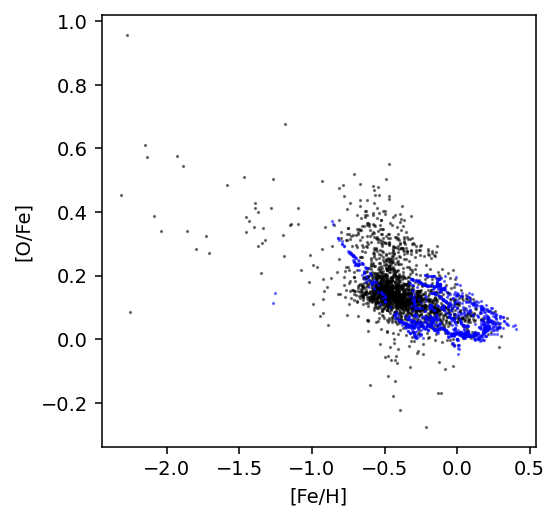

In [234]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
ax.scatter(apogee_sample['FE_H'], apogee_sample['O_FE'], c='k', alpha=0.5, s=0.5)
ax.scatter(vice_sample['[fe/h]'], vice_sample['[o/fe]'], c='b', alpha=0.5, s=0.5)
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
plt.show()

In [221]:
Psamples = apogee_subset[['FE_H', 'O_FE']]
Qsamples = vice_subset[['[fe/h]', '[o/fe]']]

KLdivergence(Psamples, Qsamples)

6.213300557050426

In [211]:
sample1 = sample_dataframe(apogee_subset, 10000)
sample2 = sample_dataframe(apogee_subset, 10000)
KLdivergence(sample1[['FE_H', 'O_FE']], sample2[['0_H', 'O_FE']])

[0.00252147 0.00083904 0.00124452 ... 0.00200562 0.00093451 0.00287741]
[0.         0.         0.00054731 ... 0.00131604 0.00243709 0.        ]
[ 0.          0.         -0.82149173 ... -0.42132505  0.95853995
  0.        ]


/tmp/ipykernel_129/1060652836.py:48: RuntimeWarning: divide by zero encountered in log
  logsr = np.log(s/r)


0.01281918538945811